# Loan Club: Machine Learning Capstone Notebook

In [77]:
# Load packages
import pandas as pd
import numpy as np
import re
from time import strptime  # format data columns
import warnings
import math

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")  # ignore warnings throughout notebook
pd.set_option("display.max_columns", None)  # show all columns

In [78]:
# Used for auto-formatting code
# terminal - pip install nb_black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [25]:
# Load Data
filepath = "../data/accepted_subsampled_5percent.csv" #will be personalized
df = pd.read_csv(filepath, sep=",")

df_cleaned = df.copy() #work from second copy

In [26]:
# Features known to investors based on LC website
known_vars = ['acc_now_delinq',             # accounts now deliquent
              'collections_12_mths_ex_med', # collections excluding medical
              'fico_range_high',            # credit score range
              'fico_range_low',             # creit score range
              'delinq_2yrs',                # delinquencies in last two years
              'delinq_amnt',                # delinquency amount
              'earliest_cr_line',           # earliest credit line
              'home_ownership',             # home ownership
              'dti',                        # debt2income ratio
              'annual_inc',                 # annual income
              'initial_list_status',        # initial listing status
              'inq_last_6mths',             # credit inquires in last 6mo
              'int_rate',                   # interest rate
              'verification_status_joint',  # is this a joint app
              'emp_length',                 # length of employment (yr)
              'loan_amnt',                  # loan amount
              'id',                         # loan id
              'purpose',                    # purpose of the loan
              'term',                       # loan term (3 or 5yr)
              'addr_state',                 # borrower location state
              'installment',                # montly payment
              'mths_since_last_delinq',     # mo since last delinquency
              'mths_since_last_major_derog',# mo since last maj. derogatory
              'mths_since_last_record',     # mo since last public record
              'open_acc',                   # open credit line
              'pub_rec',                    # public records on file
              'revol_util',                 # revolving balance utilization (%)
              'revol_bal',                  # revolving credit balance ($)
              'tot_coll_amt',               # total collection amount ever
              'total_acc',                  # total credit lines
              'tot_cur_bal',                # total current balance
              'verification_status',        # verified income (Y/N I think)
              'grade'                       # loan grade
             ]

# Sanity check, print variable if not found within original dataframe
# [ print(var) for var in known_vars if (var not in df.columns)]


### Impute Missing Data of Known Variables

In [27]:
#Assess missingness of known variables
missingness = df_cleaned[known_vars].isnull().mean().T
missingness = missingness.loc[missingness>0].sort_values(ascending=False)
missingness


verification_status_joint      0.949313
mths_since_last_record         0.838543
mths_since_last_major_derog    0.744395
mths_since_last_delinq         0.513786
emp_length                     0.063868
tot_cur_bal                    0.033430
tot_coll_amt                   0.033430
revol_util                     0.001006
dti                            0.000829
collections_12_mths_ex_med     0.000476
open_acc                       0.000185
pub_rec                        0.000185
total_acc                      0.000185
inq_last_6mths                 0.000185
earliest_cr_line               0.000185
delinq_amnt                    0.000185
delinq_2yrs                    0.000185
acc_now_delinq                 0.000185
dtype: float64

In [28]:
# Drop features missing > 50% 
feat_wManyMissing = missingness.index[np.where(missingness > .5)].to_list()
df_cleaned[known_vars].drop(df_cleaned[feat_wManyMissing], axis=1, inplace=True)
[known_vars.remove(var) for var in feat_wManyMissing] #remove features from known_var list
print('Features successfully droppped')

Features successfully droppped


In [29]:
# Replace NA's of numeric 'known_var' features with mean value
numeric_var = ['tot_cur_bal',
               'tot_coll_amt',
               'revol_util',
               'collections_12_mths_ex_med',
               'open_acc',
               'pub_rec',
               'total_acc',
               'inq_last_6mths',
               'delinq_amnt',
               'delinq_2yrs',
               'dti' ]

# List comprehension through numerica variables
[df_cleaned[var].fillna(df[var].mean(), inplace=True) for var in numeric_var]
print('Continuous Variables: Mean imputation completed')

Mean imputation completed


In [30]:
# Helper function to replace missing character strings with randomly selected value
def fillna_random(var):
    #find index of missing values
    miss_idx = df_cleaned.loc[ df_cleaned[var].isnull()].index.tolist()
    
    #find new values to replace NaN values
    new_val = df_cleaned[var].loc[~df_cleaned.index.isin(miss_idx)].sample(len(miss_idx)).values.tolist()

    #replace values
    df_cleaned[var][miss_idx] = new_val

# ==================================================
# Replace NA's of character 'known_var' features with random
non_numeric_var = ['emp_length', 'earliest_cr_line', 'acc_now_delinq', 'delinq_2yrs'] #list of non-numeric variables
[fillna_random(var) for var in non_numeric_var]
print('Categorical Variables: Imputation with random value completed')


Categorical Variables: Imputation with random value completed


In [31]:
#Sanity check that no more missing values
df_cleaned[known_vars].isnull().sum()


acc_now_delinq                0
collections_12_mths_ex_med    0
fico_range_high               0
fico_range_low                0
delinq_2yrs                   0
delinq_amnt                   0
earliest_cr_line              0
home_ownership                0
dti                           0
annual_inc                    0
initial_list_status           0
inq_last_6mths                0
int_rate                      0
emp_length                    0
loan_amnt                     0
id                            0
purpose                       0
term                          0
addr_state                    0
installment                   0
open_acc                      0
pub_rec                       0
revol_util                    0
revol_bal                     0
tot_coll_amt                  0
total_acc                     0
tot_cur_bal                   0
verification_status           0
grade                         0
dtype: int64

### Feature Engineering

In [32]:
# Simplify loan status (non-FullyPaid or ChargedOff loans will be converted to NAN)
df_cleaned['loan_status'] = df_cleaned['loan_status'].map({'Fully Paid':'Fully Paid',
                                                           'Charged Off':'Charged Off',
                                                           'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
                                                           'Does not meet the credit policy. Status:Charged Off': 'Charged Off'})

# Remove non-completed loans
df_cleaned.drop(df_cleaned.loc[df_cleaned['loan_status'].isnull()].index.tolist(), axis=0, inplace=True)

# Simplify home ownership
df_cleaned['home_ownership'] = df_cleaned['home_ownership'].map({'MORTGAGE':'mortgage',
                                                                 'OWN':'own',
                                                                 'RENT':'rent'})

# Remove 25 observations without houses
df_cleaned.drop(df_cleaned.loc[df_cleaned['home_ownership'].isnull()].index.tolist(), axis=0, inplace=True)


# Reformat date features and calculate features related to prepayment  
df_cleaned['term_year'] = np.where(df_cleaned['term']==' 36 months', 3,5)
df_cleaned['earliest_cr_line'] =  pd.to_datetime(df_cleaned['earliest_cr_line'])
df_cleaned['issue_date'] =  pd.to_datetime(df_cleaned['issue_d'])
df_cleaned['last_pymnt_date'] = pd.to_datetime(df_cleaned['last_pymnt_d'])
df_cleaned['exp_last_pymnt_date'] = pd.to_datetime(df_cleaned['issue_d'].str[0:3]
                                                   +'-'
                                                   + (df_cleaned['issue_d'].str[-4:].astype('int')
                                                   + df_cleaned['term_year']).astype('str'))

# Calculate credit history ( in months )
date_ofloan = df_cleaned['issue_date'].dt.to_period('M').astype(int)
date_credline = df_cleaned['earliest_cr_line'].dt.to_period('M').astype(int)
df_cleaned['credit_hist_mths'] = date_ofloan - date_credline
df_cleaned['credit_hist_mths'] = np.where(df_cleaned['credit_hist_mths'] < 0, 0, df_cleaned['credit_hist_mths'])

# Log-transform skewed continuous features
df_cleaned['delinq_amnt_log'] = df_cleaned['delinq_amnt'].add(1).apply(np.log)
df_cleaned['annual_inc_log'] = df_cleaned['annual_inc'].add(1).apply(np.log)
df_cleaned['dti_log'] = df_cleaned['dti'].add(1).apply(np.log)
df_cleaned['funded_amnt_log'] = df_cleaned['funded_amnt'].add(1).apply(np.log)
df_cleaned['tot_coll_amt_log'] = df_cleaned['tot_coll_amt'].add(1).apply(np.log)
df_cleaned['tot_cur_bal_log'] = df_cleaned['tot_cur_bal'].add(1).apply(np.log)
df_cleaned['total_acc_log'] = df_cleaned['total_acc'].add(1).apply(np.log)
df_cleaned['revol_bal_log'] = df_cleaned['revol_bal'].add(1).apply(np.log)
df_cleaned['installment_log'] = df_cleaned['installment'].add(1).apply(np.log)
df_cleaned['open_acc_log'] = df_cleaned['open_acc'].add(1).apply(np.log)

# Simplify loan purpose - debt consolidation, credit card, and other
df_cleaned['purpose'] = df_cleaned['purpose'].map({'debt_consolidation':'debt_consolidation',
                                                   'credit_card':'credit_card'})
df_cleaned['purpose'].fillna('other',inplace=True)

# Convert loan grade to ordinal feature
df_cleaned['grade'] = df_cleaned['grade'].map({'A':1,
                                               'B':2,
                                               'C':3,
                                               'D':4,
                                               'E':5,
                                               'F':6,
                                               'G':7})

# Simplify employment length to four categories
df_cleaned['emp_length'] = df_cleaned['emp_length'].map({'< 1 year':0.5,
                                                         '1 year':1,
                                                         '2 years':2,
                                                         '3 years':3,
                                                         '4 years':4,
                                                         '5 years':5,
                                                         '6 years':6,
                                                         '7 years':7,
                                                         '8 years':8,
                                                         '9 years':9,
                                                         '10+ years':10})

# Create new binary features
df_cleaned['has_pub_rec'] = np.where(df_cleaned['pub_rec']>0,1,0) #0-=no public record
df_cleaned['has_paid_early'] = np.where((df_cleaned.loan_status=='Fully Paid')&(df_cleaned.last_pymnt_date < df_cleaned.exp_last_pymnt_date), 1, 0)
df_cleaned['has_36mo_loan'] = np.where(df_cleaned['term'].str.contains('36'),1,0) #0=60mo loan
df_cleaned['has_delinq_now'] = np.where(df_cleaned['acc_now_delinq']>0, 1, 0)
df_cleaned['has_delinq_past2yrs'] = np.where(df_cleaned['delinq_2yrs']>0, 1, 0) #0=no delinq within 2yrs
df_cleaned['has_whole_liststatus'] = np.where(df_cleaned['initial_list_status']=='w', 1, 0) #0=f
df_cleaned['has_fullypaid'] = np.where(df_cleaned['loan_status']=='Fully Paid', 1, 0) #0=charged off


In [33]:
# Create response variable based on 
threshold = -20 #goal % return
df_cleaned["roi_perc"] = df_cleaned["total_pymnt"].div(df_cleaned["funded_amnt"]).sub(1).mul(100)
df_cleaned['roi_response'] = np.where(df_cleaned['roi_perc'] > threshold, 1, 0)

print('Fraction of loans above threadhold: %.3f' % df_cleaned['roi_response'].mean())

# ==================================================================
# Majority class [1] = ROI >-20% (IDEAL)
# Minority class [0] = ROI <-20% (BAD)

Fraction of loans above threadhold: 0.838


In [34]:
# Isolate list of predictor variables to be used for ML
predictor_vars = ['annual_inc_log',
                  'credit_hist_mths',
                  'delinq_amnt_log',
                  'dti_log',
                  'emp_length',
                  'fico_range_high',
                  'funded_amnt_log',
                  'grade',
                  'has_36mo_loan',
                  'has_delinq_now',
                  'has_delinq_past2yrs',
                  'has_pub_rec',
                  'has_whole_liststatus',
                  'home_ownership',
                  'inq_last_6mths',
                  'installment_log',
                  'int_rate',
                  'open_acc_log',
                  'purpose',
                  'revol_bal_log',
                  'revol_util',
                  'tot_coll_amt_log',
                  'tot_cur_bal_log',
                  'total_acc_log',
                  'verification_status']

response_var = 'roi_response'


# Machine Learning

### Data Preparation

In [35]:
# Dummify categorical features
home_ownership_dummy = pd.get_dummies(df_cleaned['home_ownership'],
                                      prefix="home_ownership").drop('home_ownership_mortgage',axis=1)

purpose_dummy = pd.get_dummies(df_cleaned['purpose'],
                               prefix="purpose").drop('purpose_debt_consolidation',axis=1)

verification_status_dummy = pd.get_dummies(df_cleaned['verification_status'],
                               prefix="verification_status").drop('verification_status_Source Verified',axis=1)


In [36]:
# List of numeric features in the final dataframe
numeric_vars = ['annual_inc_log',
                'credit_hist_mths',
                'delinq_amnt_log',
                'dti_log',
                'emp_length',
                'fico_range_high',
                'funded_amnt_log',
                'grade',
                'has_36mo_loan',
                'has_delinq_now',
                'has_delinq_past2yrs',
                'has_pub_rec',
                'has_whole_liststatus',
                'inq_last_6mths',
                'installment_log',
                'int_rate',
                'open_acc_log',
                'revol_bal_log',
                'revol_util',
                'tot_coll_amt_log',
                'tot_cur_bal_log',
                'total_acc_log']


In [37]:
# final dataframe for model consumption
df_feature_final = pd.concat([df_cleaned[numeric_vars],
                      home_ownership_dummy,
                      purpose_dummy,
                      verification_status_dummy],axis=1)

### Logistic Regression
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

### Tree-Based Model
- Goal is to build classifier that predicts if loan results in desirable outcome
- Should also report feature importance

- Initially explored Random Forest algorithm but switched to XGboost due to time constraint


In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, auc, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#### Naive XGBoost Model - Imbalanced Data (83.8% ROI>-20%)

*Goal is to minimize false positives* - Maximixe precision
- Majority class [1] = ROI >-20% (IDEAL)
- Minority class [0] = ROI <-20% (BAD)


In [40]:
#Create test-train split of data
x = df_feature_final
y = df_cleaned[response_var] #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [42]:
#Create random forest object
naive_model = xgb.XGBClassifier(objective = 'binary:logistic', 
                                seed = 0)

#Fit model with data
naive_model.fit(x_train, y_train)

#Analyze
model = naive_model
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(x_test)).ravel()
results = {'auc_PR': round(average_precision_score(y_test, model.predict(x_test)),4),
           'accuracy': round((tp + tn) / (tp + tn + fn + fp),4),
           'recall': round(tp / (tp + fn),4),
           'precision': round(tp/(tp+fp),4),
           'false_discovery_rate': round(fp/(fp+tp),4),
           'false_pos_rate': round(fp / (tn + fp),4),
           'error_rate': round((fp + fn) / (tp + tn + fn + fp),4),
           'n_true_pos':tp,
           'n_false_pos':fp}
results

# # ==================== Print Results ====================
# model = naive_model
# y_pred = model.predict(x_test)
# auc_PR = average_precision_score(y_test, y_pred)
# precision, recall, _ = precision_recall_curve(y_test, y_pred)
# plt.plot(recall, precision)
# plt.xlabel('Recall (True Positive) ')
# plt.ylabel('Precision (Proportion Correct)')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Binary Precision-Recall curve: '
#                    'auc_PR={0:0.2f}'.format(auc_PR))

{'auc_PR': 0.841,
 'accuracy': 0.8384,
 'recall': 0.9955,
 'precision': 0.841,
 'false_discovery_rate': 0.159,
 'false_pos_rate': 0.9785,
 'error_rate': 0.1616,
 'n_true_pos': 11323,
 'n_false_pos': 2140}

#### Naive XGBoost Model - using scale_pos_weight parameter

In [44]:
#Create random forest object
#scale_pos_weight = sum(negative) / sum(positive)
naive_spw_model = xgb.XGBClassifier(objective = 'binary:logistic',
                                    scale_pos_weight=(len(y)-y.sum())/y.sum(), #0.1929
                                    seed = 0)

#Fit model with data
naive_spw_model.fit(x_train, y_train)

#Analyze
model = naive_spw_model
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(x_test)).ravel()
naive_spw_results = {'weight': round((len(y)-y.sum())/y.sum(),4),
                     'auc_PR': round(average_precision_score(y_test, model.predict(x_test)),4),
                     'accuracy': round((tp + tn) / (tp + tn + fn + fp),4),
                     'recall': round(tp / (tp + fn),4),
                     'precision': round(tp/(tp+fp),4),
                     'false_discovery_rate': round(fp/(fp+tp),4),
                     'false_pos_rate': round(fp / (tn + fp),4),
                     'error_rate': round((fp + fn) / (tp + tn + fn + fp),4),
                     'n_true_pos':tp,
                     'n_false_pos':fp}
naive_spw_results

# # ==================== Print Results ====================
# model = naive_model
# y_pred = model.predict(x_test)
# auc_PR = average_precision_score(y_test, y_pred)
# precision, recall, _ = precision_recall_curve(y_test, y_pred)
# plt.plot(recall, precision)
# plt.xlabel('Recall (True Positive) ')
# plt.ylabel('Precision (Proportion Correct)')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Binary Precision-Recall curve: '
#                    'auc_PR={0:0.2f}'.format(auc_PR))

{'weight': 0.1929,
 'auc_PR': 0.8833,
 'accuracy': 0.6413,
 'recall': 0.6363,
 'precision': 0.9087,
 'false_discovery_rate': 0.0913,
 'false_pos_rate': 0.3324,
 'error_rate': 0.3587,
 'n_true_pos': 7237,
 'n_false_pos': 727}

**Tuning Hyperparameters**
- max_depth = depth of trees (3-10)
- min_child_weight = similar to min_child_leaf for RandomForest
- gamma = min. loss reduction required for split
- subsample = frac of observations randomly sampled for tree (0.5-1)
- colsample_bytree = number of features sampled for each tree
- learning rate = typically between 0.01-0.2

In [45]:
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
# from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


In [46]:
# def grid_search_wrapper(refit_score='precision_score'):
#     """
#     fits a GridSearchCV classifier using refit_score for optimization
#     prints classifier performance metrics
#     """
    
#     skf = StratifiedKFold(n_splits=5)
#     grid_search = GridSearchCV(model,
#                                      param_grid,
#                                      scoring=scorers,
#                                      refit=refit_score,
#                                      cv=skf,
#                                      verbose=1,
#                                      return_train_score=True,
#                                      n_jobs = -1)
    
#     grid_search.fit(x_train, y_train)

#     # make the predictions
#     y_pred = grid_search.predict(x_test)

#     print('Best params for {}'.format(refit_score))
#     print(grid_search.best_params_)

#     # confusion matrix on the test data.
#     print('\nConfusion matrix of XGBoost optimized for {} on the test data:'.format(refit_score))
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#     precision = round(tp/(tp+fp),4) * 100
#     print("\nPrecision: {0}% of loans identified as a good loan (ROI>-20%) were correct\n".format(precision))

#     false_discovery_rate = round(fp/(fp+tp),4) * 100
#     print("False discovery rate: {0}% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]\n\n".format(false_discovery_rate))

#     return grid_search

In [47]:
# %%time
# #Based on link: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

# xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',
#                               early_stopping_rounds = 5,
#                               scale_pos_weight = (len(y)-y.sum())/y.sum())


# c

# scorers = {
#     'precision_score': make_scorer(precision_score),
# }

# grid_search_model = grid_search_wrapper(refit_score='precision_score')



## Results

### Naive Model

In [48]:
#Confusion Matrix
y_pred = naive_spw_model.predict(x_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

#CM Calculations
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

accuracy = round( 100*(tp + tn) / (tp + tn + fn + fp) ,2)
print("\nAccuracy: {0}% of loans were correctly identified\n".format(accuracy))

specificity = round(tn / (tn + fp),4) * 100 #true negative rate
print("Specificity: {0}% of loans with ROI<-20% were identified as a bad loan loan\n".format(specificity))

recall = round(tp / (tp + fn), 4) * 100 #true positive rate
print("Recall/Sensitivity: {0}% of loans with ROI>-20% were identified as a good loan\n".format(recall))

precision = round(tp/(tp+fp),4) * 100
print("Precision: {0}% of loans identified as a good loan (ROI>-20%) were correct\n".format(precision))

false_discovery_rate = round(fp/(fp+tp),4) * 100
print("False discovery rate: {0}% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]\n".format(false_discovery_rate))

false_pos_rate = round(fp / (tn + fp),4) * 100
print("False Positive Rate: {0}% of bad loans [ROI<-20%] were identified as a good loan [ROI>-20%]\n".format(false_pos_rate))


     pred_neg  pred_pos
neg      1460       727
pos      4137      7237

Accuracy: 64.13% of loans were correctly identified

Specificity: 66.75999999999999% of loans with ROI<-20% were identified as a bad loan loan

Recall/Sensitivity: 63.629999999999995% of loans with ROI>-20% were identified as a good loan

Precision: 90.86999999999999% of loans identified as a good loan (ROI>-20%) were correct

False discovery rate: 9.13% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]

False Positive Rate: 33.239999999999995% of bad loans [ROI<-20%] were identified as a good loan [ROI>-20%]



### Balanced Model

In [50]:
xgb_balanced = xgb.XGBClassifier(objective = 'binary:logistic',
                              early_stopping_rounds = 5,
                              scale_pos_weight = (len(y)-y.sum())/y.sum(),
                              seed = 0,
                              colsample_bytree = 0.9, 
                              max_depth = 1, 
                              n_estimators = 500,
                              subsample = 0.5,
                              n_jobs = -1)

xgb_balanced.fit(x_train, y_train)

#Confusion Matrix
y_pred = xgb_balanced.predict(x_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

# #CM Calculations
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(x_test)).ravel()

accuracy = round( 100*(tp + tn) / (tp + tn + fn + fp) ,2)
print("\nAccuracy: {0}% of loans were correctly identified\n".format(accuracy))

specificity = round(tn / (tn + fp),4) * 100 #true negative rate
print("Specificity: {0}% of loans with ROI<-20% were identified as a bad loan loan\n".format(specificity))

recall = round(tp / (tp + fn), 4) * 100 #true positive rate
print("Recall/Sensitivity: {0}% of loans with ROI>-20% were identified as a good loan\n".format(recall))

precision = round(tp/(tp+fp),4) * 100
print("Precision: {0}% of loans identified as a good loan (ROI>-20%) were correct\n".format(precision))

false_discovery_rate = round(fp/(fp+tp),4) * 100
print("False discovery rate: {0}% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]\n".format(false_discovery_rate))

false_pos_rate = round(fp / (tn + fp),4) * 100
print("False Positive Rate: {0}% of bad loans [ROI<-20%] were identified as a good loan [ROI>-20%]\n".format(false_pos_rate))



     pred_neg  pred_pos
neg      1471       716
pos      4229      7145

Accuracy: 64.13% of loans were correctly identified

Specificity: 66.75999999999999% of loans with ROI<-20% were identified as a bad loan loan

Recall/Sensitivity: 63.629999999999995% of loans with ROI>-20% were identified as a good loan

Precision: 90.86999999999999% of loans identified as a good loan (ROI>-20%) were correct

False discovery rate: 9.13% of loans identified as good [ROI>-20%] were actually bad loans [ROI<-20%]

False Positive Rate: 33.239999999999995% of bad loans [ROI<-20%] were identified as a good loan [ROI>-20%]



#### Feature Importance

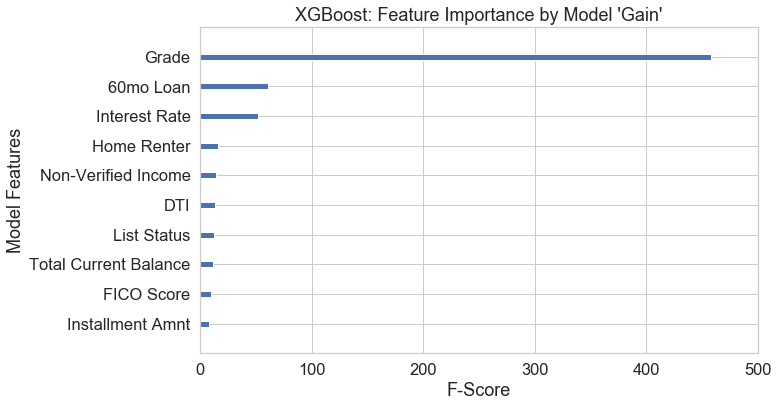

<IPython.core.display.Javascript object>

In [84]:
plt.rcParams["figure.figsize"] = (10, 6)
ax = xgb.plot_importance(
    xgb_balanced,
    ax=None,
    title="XGBoost: Feature Importance by Model 'Gain'",
    xlabel="F-Score",
    ylabel="Model Features",
    importance_type="gain",
    max_num_features=10,
    grid=True,
    show_values=False,
    xlim=(0, 500),
)

tick_labels = [
    "Installment Amnt",
    "FICO Score",
    "Total Current Balance",
    "List Status",
    "DTI",
    "Non-Verified Income",
    "Home Renter",
    "Interest Rate",
    "60mo Loan",
    "Grade",
]
ax.set_yticklabels(tick_labels)

plt.savefig("xgboost_feature_importance.pdf", bbox_inches="tight")


In [150]:
# Export Results

xgboost_output = pd.concat([x_test, y_test], axis=1)
xgboost_output['y_predict'] = y_pred

xgboost_output = pd.merge(xgboost_output, df_cleaned["roi_perc"], left_on = xgboost_output.index, right_on = df_cleaned["roi_perc"].index)

xgboost_output.to_csv(path_or_buf = 'xgboost_output.csv',sep=',')